In [1]:
import oracledb
import cx_Oracle
from datetime import datetime, timedelta, time, date
import numpy as np
from scipy.interpolate import splrep, splev
import csv
import pickle
from pathlib import Path
import os


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import SplineTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.neural_network import MLPRegressor


from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer

from sklearn.decomposition import PCA, KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.utils import shuffle

from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import median_absolute_error 

from tpot import TPOTRegressor
from sklearn.decomposition import FastICA
from sklearn.kernel_approximation import RBFSampler


F:\ruslan\projects\forecaster\env_fcr\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


#### Функция чтения данных из БД

In [2]:
def read_temperature_from_db(start_date, finish_date):

    try:
        cx_Oracle.init_oracle_client(lib_dir=r"F:\ruslan\dev\oracle\instantclient_19_9")
    except:
        pass
    
    conn_nwp = oracledb.connect(user="nwp", password="modeli", dsn="192.168.211.62/serv")
    cursor_nwp = conn_nwp.cursor()
    
    cursor_nwp.execute("""
    /* SELECT to_char(DATAS, 'YYYY-MM-DD'), ADVANCE_TIME,  TEMP */
    SELECT DATAS, ADVANCE_TIME,  TEMP
    FROM NWP.GROUND_DATA
    WHERE CITY_ID = 936 
          AND model_id = 4
          AND ADVANCE_TIME between 0 and 48
          /*AND datas >= '01-08-2022'*/
          /*AND datas between '01-08-2022' and '31-12-2022'*/
          AND datas >= :start_date
          AND to_char(datas, 'HH24') = '00'
    ORDER BY datas, advance_time
    """,
    start_date=start_date
    )
    
    date = None
    forecast_arr = []
    f_row = [] 
    for c in cursor_nwp:
        # Нова дата - создаем новую строку данных
        if date != c[0]:
            # Если дата пройдена, присоединить строку данных f_row к массиву forecast_arr
            if date:
                forecast_arr.append(f_row) 
            # Инициализируем следующую дату и строку данных
            date = c[0]       
            f_row = [None for _ in range(50)]
            f_row[0] = c[0] # Дату c[0] записать в позицию 0
        # В позицию списка, равную заблаговременности c[1] записать температуру c[2]
        f_row[c[1] + 1] = c[2]
    # Присоединить последнюю строку данных f_row к массиву forecast_arr
    forecast_arr.append(f_row)        
    # print(*forecast_arr, sep='\n')
    conn_nwp.close()
    
    
    conn_gts = cx_Oracle.connect(user="cligts", password="belorgmc", dsn="192.168.211.173/clidb")
    cursor_gts = conn_gts.cursor()
    
    cursor_gts.execute(
    """
    SELECT DATE_OBS, TEMPDB
    FROM gts.synop
    WHERE 
      /*date_obs >= '01-08-2022'*/
      /* date_obs between '01-08-2022' and '31-12-2022' */
      date_obs >= :start_date
      AND station_id = '26850'
    """,
    start_date=start_date
    )
    
    gts_rows = cursor_gts.fetchall()
    # for c in gts_rows:
    #     print(c)
    
    conn_gts.close()
    
    
    # Формирование y - значений фактической температуры, соответствующих каждой дате на 48 часов вперед
    # Поиск каждой совпадающей строки по дате и сроку 00
    start = 0
    fact_arr = []
    forecast_X = []
    td48 = timedelta(hours=48)
    for f in forecast_arr:
        date_nwp = f[0]
        # Прервать выполнение, если от даты прогноза до текущего момента 
        # прошло менее или ровно 48 часов, т.к. не будет соответствующих фактических данных
        if datetime.today() - date_nwp <= td48:
            print(datetime.today() - date_nwp)
            print(f'Прервано - для даты {date_nwp} не хватит фактических данных!')
            break
        # print('NWP Date:', date_nwp)
        # print('GTS start:', start)
        for i, g in enumerate(gts_rows[start:]):
            if g[0] == f[0]: # Строка найдена
                # print(f[0])
                start += i
                forecast_X.append(f)
                break
        # Инициализировать строку данных для фактической температуры 17 значений
        g_row = [None for _ in range(18)]
        g_row[0] = g[0]
        # print('GTS Date:', g[0])
        for j in range(17):
            gts_date = gts_rows[start + j][0]
            gts_temperature = gts_rows[start + j][1]
            td = gts_date - date_nwp
            # print('Time delta for g_row:', td, 'Temper;', gts_temperature)
            # В пределах 48 часов
            if td <= td48:
                td_hours = int(td.days * 24 + td.seconds / 3600)
                # print('td_hours', td_hours)
                cell = td_hours // 3
                # print('cell', cell)
                g_row[cell + 1] = gts_temperature
            else:
                # start += i #!!!!
                print('BREAK!!!')
                break
        fact_arr.append(g_row)
        # print(g_row)
    
    # print(*forecast_arr, sep='\n')
    # print('Fact:')
    # print(*fact_arr, sep='\n')
    
    fact_y = fact_arr
    
    
    
    # Проверка на пропущенные значения (None)
    damaged_rows = set()
    
    for i, (x, y) in enumerate(zip(forecast_X, fact_y)):
        
        if x[0] != y[0]:
            damaged_rows.add(i)
            print('Damaged dates:', x[0], y[0])
        
        damage_x = False
        for xi in x: 
            if xi is None:
                damage_x = True
                break
        if damage_x:
            damaged_rows.add(i)
            print('x', x)
        
        damage_y = False
        for yi in y: 
            if yi is None:
                damage_y = True
                break
        if damage_y:
            damaged_rows.add(i)
            print('y', y)
    
    damaged_rows = sorted(list(damaged_rows), reverse=True)
    print(damaged_rows)
    
    # Удаление строк с пропусками
    for i in damaged_rows:
        forecast_X.pop(i)
        fact_y.pop(i)

    return forecast_X, fact_y

In [3]:
# forecast, fact = read_temperature_from_db('01-11-2022', '')

#### Функция записи датасетов в файлы CSV

In [4]:
def write_csv(forecast, fact, forecast_model, z=48, append=True):
    mode = 'at' if append else 'wt'
    # Запись прогноза
    forecast_header = ['date_term'] + [f'z_{x}' for x in range(z + 1)]
    with open(f'data/forecast_{forecast_model}.csv', mode, newline='') as f_forecast:
        forecast_writer = csv.writer(f_forecast, delimiter=';')
        if mode == 'wt':
            forecast_writer.writerow(forecast_header)
        forecast_writer.writerows(forecast)
    # Запись факта
    fact_header = ['date'] + [f't_{x % 24}' for x in range(0, z + 1, 3)]
    with open(f'data/fact.csv', mode, newline='') as f_fact:
        fact_writer = csv.writer(f_fact, delimiter=';')
        if mode == 'wt':
            fact_writer.writerow(fact_header)
        fact_writer.writerows(fact)

    # Запись файла с датой последних данных в датасетах
    date_time = forecast[-1][0]
    write_last_date_file(date_time)

#### Функция записи файла с датой последних данных в датасетах

In [5]:
def write_last_date_file(date_time):
    with open(f'data/last_date.txt', 'wt') as f:
        f.write(str(date_time))

#### Функция чтения файла с датой последних данных в датасетах

In [6]:
def read_last_date_file():
    with open(f'data/last_date.txt', 'rt') as f:
        date_time_str = f.readline()
        date_time = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
    return date_time

In [7]:
# read_last_date_file()

## Функция создания на диске датасетов forecast, fact

In [8]:
def create_datasets(start_date, forecast_model, z=48):
    forecast, fact = read_temperature_from_db(start_date, '')
    write_csv(forecast, fact, forecast_model, z=z, append=False)

In [9]:
# create_datasets('01-11-2022', 'gfs', z=48)

## Функция обновления датасетов новыми данными

In [10]:
def update_datasets(forecast_model, z=48):
    update_date_time = read_last_date_file() + timedelta(hours=24)
    date_str = update_date_time.strftime('%d-%m-%Y')    
    forecast, fact = read_temperature_from_db(date_str, '')
    if forecast:
        write_csv(forecast, fact, forecast_model, z=z, append=True)
    else:
        print(f'Прервано - для даты {update_date_time} не хватит фактических данных!')

In [11]:
# update_datasets('gfs', z=48)

#### Функция чтения датасетов из csv файлов

In [12]:
def read_datasets(forecast_model, train_date=None):
    if train_date:
        train_datetime_obj = datetime.strptime(train_date, '%d-%m-%Y')

    forecast = []
    with open(f'data/forecast_{forecast_model}.csv', 'rt', newline='') as f_forecast:
        forecast_reader = csv.reader(f_forecast, delimiter=';')
        forecast_header = next(forecast_reader)
        for row in forecast_reader:
            r = []
            for i, e in enumerate(row):
                if i == 0:
                    row_date = datetime.strptime(e, '%Y-%m-%d %H:%M:%S')
                    if train_date and row_date > train_datetime_obj:
                        break  
                    r.append(row_date)
                else:
                    r.append(float(e))
            else:
                forecast.append(r)
                continue
            break

    fact = []
    with open('data/fact.csv', 'rt', newline='') as f_fact:
        fact_reader = csv.reader(f_fact, delimiter=';')
        fact_header = next(fact_reader)
        for row in fact_reader:
            r = []
            for i, e in enumerate(row):
                if i == 0:
                    row_date = datetime.strptime(e, '%Y-%m-%d %H:%M:%S')
                    if train_date and row_date > train_datetime_obj:
                        break  
                    r.append(row_date)
                else:
                    r.append(float(e))
            else:
                fact.append(r)
                continue
            break

    return forecast, fact

In [13]:
# forecast, fact = read_datasets('gfs')
# print(len(forecast))
# print(len(fact))
# print(forecast[-1])
# print(fact[-1])

#### Функция подготовки X и y

In [14]:
def get_xy(forecast, fact):
    print('get_xy1')
    print(len(forecast))
    print(len(fact))
    X = np.array([xx[1:] for xx in forecast])
    y = np.array([yy[1:] for yy in fact])
    print("get_xy2")
    print(X.shape)
    print(y.shape)
    return X, y

#### Функция интерполяции строк целевых значений y

In [15]:
def interpolate_y_rows(arr, knots, degree=2):
    x = np.linspace(0, arr.shape[1], arr.shape[1])
    x_knots = np.linspace(0, arr.shape[1], knots)
    arr_new = []
    for y in arr:
        x_spl = splrep(x, y, k=degree)
        y2 = splev(x_knots, x_spl)
        arr_new.append(y2)

    
    return np.array(arr_new)


#### Функция аугментации данных

In [16]:
def augment_data(x_data, y_data, knots, degree=2):
    data_len = len(y_data)
    prior_points = np.linspace(0, data_len, data_len)
    
    xy = []
    for z in (x_data, y_data):
        z_splitted = np.hsplit(z, z.shape[1])
        #print(x_splitted)
        z_list = []
        for arr in z_splitted:
            z_spl = splrep(prior_points, arr, k=degree)
            z_points_n = np.linspace(0, data_len, knots)
            z_col_augmented = splev(z_points_n, z_spl)
            z_list.append(z_col_augmented)
        z_augmented = np.array(z_list).T
        xy.append(z_augmented)
    
    x_result, y_result = xy
    return x_result, y_result

#### Функция получения трансформеров данных

In [17]:
def get_transformer(transformer, n_samples=10_000):
    scaler = (
        StandardScaler() if transformer == 'standard' else \
        MinMaxScaler() if transformer == 'minmax' else \
        MaxAbsScaler() if transformer == 'maxabs' else \
        RobustScaler() if transformer == 'robust' else \
        QuantileTransformer(output_distribution='uniform', n_quantiles=min(10_000, n_samples), random_state=0) if transformer == 'uniform' else \
        QuantileTransformer(output_distribution='normal', n_quantiles=min(10_000, n_samples), random_state=0) if transformer == 'normal' else \
        PowerTransformer(method='box-cox', standardize=False) if transformer == 'normal-bc' else \
        PowerTransformer(method='yeo-johnson', standardize=False) if transformer == 'normal-yj' else \
        PowerTransformer(method='box-cox', standardize=True) if transformer == 'normal-bc-st' else \
        PowerTransformer(method='yeo-johnson', standardize=True) if transformer == 'normal-yj-st' else \
        None
    )
    return scaler

#### Функция вычисления качества моделей

In [18]:
def quality(y_true, predicted):
    q = {}
    q["r2_score"] = r2_score(y_true, predicted) #q_max_error 
    # q[max_error] = max_error(y_true, predicted) #q_max_error 
    q["mean_absolute_error"] = mean_absolute_error(y_true, predicted) #q_mean_absolute_error
    q["mean_squared_error"] = mean_squared_error(y_true, predicted) #q_mean_squared_error 
    # q[mean_squared_log_error] = mean_squared_log_error(y_true, predicted) #q_mean_squared_log_error 
    q["median_absolute_error"] = median_absolute_error(y_true, predicted) #q_median_absolute_error 

    print(
    f'r2_score: {q["r2_score"]}',
    # f'max_error: {q[1]}',
    f'mean_absolute_error: {q["mean_absolute_error"]}',
    f'mean_squared_error: {q["mean_squared_error"]}',
    # f'mean_squared_log_error: {q[4]}',
    f'median_absolute_error: {q["median_absolute_error"]}',
    sep='\n')
    
    return q

#### Функция записи моделей в файл

In [19]:
def write_model(model_obj, forecast_model, date_str):
    with open(f'data/{forecast_model}_{date_str}.bin', 'wb') as f:
        model_bin = pickle.dump(model_obj, f, pickle.HIGHEST_PROTOCOL)

## Функция обучения моделей и записи в виде файлов

In [20]:
def train_models(forecast_model, train_date=None):

    # Чтение данных из датасетов csv
    forecast, fact = read_datasets(forecast_model, train_date)
    print('train_models')
    print(len(forecast))
    print(len(fact))
    
    # Получение первичных данных X, y
    X_prior, y_prior = get_xy(forecast, fact)
    
    # Интерполяция фактических значений
    y = interpolate_y_rows(y_prior, 49, degree=2)
    y_points_prior = np.linspace(0, y_prior.shape[1], y_prior.shape[1])
    y_points = np.linspace(0, y_prior.shape[1], y.shape[1])
    
    # plt.plot(y_points, y[-1], 'o', y_points_int, y_int[-1])
    plt.plot(y_points_prior, y_prior[-13], 'o')
    plt.plot(y_points, y[-13])
    plt.legend()
    plt.show()
    
    
    # Аугментация данных
    X_aug, y_aug = augment_data(X_prior, y, 4000, degree=1)
    print(X_aug.shape, y_aug.shape)
    
    
    # # Разделение на тренировочный и тестовый набор
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    # print(X_train)
    X, y = shuffle(X_aug, y_aug, random_state=42)
    
    # Условия масштабирования
    # scaler_x = 'normal-yj-st'
    # scaler_y = None

    scaler_x = 'stanard'
    scaler_y = 'normal'
    
    # Подготовка трансформеров
    transformer_x = get_transformer(scaler_x, n_samples=y.shape[0]) # !!!
    transformer_y = get_transformer(scaler_y, n_samples=y.shape[0]) # !!!
    
    # Подготовка модели
    # model = KNeighborsRegressor(n_neighbors = 7)
    # model = RidgeCV()
    # model = ExtraTreesRegressor(n_estimators=150, random_state=0)
    # model = RandomForestRegressor(n_estimators=150, random_state=0)
    # model = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(), random_state=0)
    # model = MLPRegressor(hidden_layer_sizes=(49, 21, 8, 21, 49), random_state=0, max_iter=1000, alpha=0.0001, activation='relu') # +0.42247
    # model = MLPRegressor(hidden_layer_sizes=(100, 42, 8, 42, 100), random_state=0, max_iter=1000, alpha=0.0001, activation='relu')
    model = MLPRegressor(hidden_layer_sizes=(100, 42, 8, 42, 100), random_state=0, max_iter=1000, alpha=0.00005, activation='relu', early_stopping=True) # +0.9473 4000
    
    # Трансформация целевых значений y
    if scaler_y: 
        regressor = TransformedTargetRegressor(regressor=model, transformer=transformer_y)
    else:
        regressor = model
    
    # Декомпозиция
    # decomposition = PCA(n_components='mle', random_state=0, whiten = True)
    decomposition = PCA(n_components=None, random_state=0, whiten = False, svd_solver='randomized') #!! + NN
    # decomposition = IncrementalPCA(n_components=None, whiten = True)
    # decomposition = KernelPCA(
    #     n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
    # )
    
    # Трансформация признаков X
    regr = make_pipeline(transformer_x, decomposition, regressor) if transformer_x else regressor
    # regr = make_pipeline(transformer_x, regressor) if transformer_x else regressor
    
    # Обучение моделей
    regr.fit(X, y)
    
    # Запись модели в файл
    date_str = datetime.strftime(forecast[-1][0], '%Y-%m-%d-%H')
    write_model(regr, forecast_model, date_str)
    
    # Оценка качества модели
    predicted = regr.predict(X)
    r2 = regr.score(X, y)
    print(r2)
    _ = quality(y, predicted)


    # regr_p= pickle.loads(pickle.dumps(regr))
    # # Оценка качества модели
    # predicted = regr_p.predict(X)
    # r2 = regr_p.score(X, y)
    # print(r2)
    # _ = quality(y, predicted)

    

In [21]:
# train_models('gfs', '21-01-2024')

#### Функция чтения очередной строки данных для прогноза из БД

In [22]:
def read_last_X(forecast_model, forecast_date):
    
    # Коды моделей
    models = {
        'gfs': 4,
        'icon': 5,
        'orv': 100,
    }

    # Запрос
    conn_nwp = oracledb.connect(user="nwp", password="modeli", dsn="192.168.211.62/serv")
    cursor_nwp = conn_nwp.cursor()
    
    cursor_nwp.execute("""
    SELECT TEMP
    FROM NWP.GROUND_DATA
    WHERE CITY_ID = 936 
          AND model_id = :model_id
          AND ADVANCE_TIME between 0 and 48
          AND datas = :start_date
          AND to_char(datas, 'HH24') = '00'
    ORDER BY datas, advance_time
    """,
    start_date=forecast_date,
    model_id = models[forecast_model]          
    )

    db_data = cursor_nwp.fetchall()
    data = np.array([x[0] for x in db_data]).reshape((1, -1))
    print(data)
    # print(bool(data))
    print(data.size)

    conn_nwp.close()

    return data   

In [23]:
# read_last_X('orv', '09-01-2024')

#### Функция получения модели из файла

In [24]:
def read_model(forecast_model, model_date):

    # Получение списка моделей
    files = filter(lambda f: '.bin' in f, os.listdir('./data'))
    files = sorted(files, key=lambda f: datetime.strptime(f.split('_')[1].split('.')[0], '%Y-%m-%d-%H'), reverse=True)
    # print(files)

    # Вычисление строки даты в имени файла
    arg_datetime = datetime.strptime(model_date, '%d-%m-%Y')
    file_date = datetime.strftime(arg_datetime, '%Y-%m-%d')

    # Поиск имени файла, содержащего дату
    model_file = tuple(filter(lambda f: file_date in f, files))[0]
    print(model_file)
    
    # last_model_file = files[0]
    with open(f'data/{model_file}', 'rb') as m:
        model = pickle.load(m)

    return model
    
    

In [25]:
# read_model('gfs', '05-01-2024')

#### Функция вычисления прогноза на текущей строке данных X

In [26]:
def make_forecast(forecast_model, forecast_date):
    # Чтение последних данных X 
    X = read_last_X(forecast_model, forecast_date)

    # Получение модели из файла
    arg_datetime = datetime.strptime(forecast_date, '%d-%m-%Y')
    model_datetime = arg_datetime - timedelta(hours=48)
    model_date = datetime.strftime(model_datetime, '%d-%m-%Y')
    model = read_model(forecast_model, model_date)

    print('Model date', model_date)
        
    # Прогноз по модели
    predicted = model.predict(X)
    # print(predicted)
    return predicted

In [27]:
# make_forecast('gfs', '07-01-2024')


#### Функция прогнозирования на дату и записи прогноза в БД

In [28]:
def write_forecast_to_db(forecast_model, forecast_date):
    
    # Коды моделей
    models = {
        'gfs': 4,
        'icon': 5,
    }

    # Вычислить прогноз на дату
    temp_forecast = np.reshape(make_forecast(forecast_model, forecast_date),(-1, ))
    
    print('temp_forecast:')
    print(temp_forecast)

    # Сформировать список кортежей (строк) для записи в БД
    # (DATAS, MODEL_ID, ADVANCE_TIME, CITY_ID, TEMP)
    datas = datetime.strptime(forecast_date, '%d-%m-%Y')
    model_id = 100
    city_id = 936
    rows_list = []
    for advance_time, temp in enumerate(temp_forecast):
        row = (temp, datas, model_id, advance_time, city_id)
        rows_list.append(row)
        
    print(rows_list) 
    
    # Определение вида операции с БД - INSERT или UPDATE
    data_on_date = read_last_X('orv', forecast_date)
    if data_on_date.size == 0:
        # Insert statement
        sql = """
        INSERT INTO nwp.GROUND_DATA (TEMP, DATAS, MODEL_ID, ADVANCE_TIME, CITY_ID)
        VALUES (:1, :2, :3, :4, :5)
        """
    else:
        # Update statement
        sql = """
        UPDATE nwp.GROUND_DATA
        SET 
            TEMP = :1
        WHERE 
            DATAS = :2 and
            MODEL_ID = :3 and
            ADVANCE_TIME = :4 and
            CITY_ID = :5
        """
    
    # Запрос
    conn_nwp = oracledb.connect(user="nwp", password="modeli", dsn="192.168.211.62/serv")
    cursor_nwp = conn_nwp.cursor()
    cursor_nwp.executemany(sql, rows_list)
    conn_nwp.commit()

    conn_nwp.close()

    # return data   

In [29]:
# write_forecast_to_db('gfs', '23-01-2024')

#### Вычисление полинома

In [30]:
def poly(arr, deg, coef=True):
    # Построим полином 1 степени из X и y
    x = np.arange(arr.shape[1])
    poly = np.polynomial.polynomial.polyfit(x, arr.T, deg=deg)
    if coef:
        return poly.T
    arr_poly = np.polynomial.polynomial.polyval(x, poly)  
    return arr_poly

#### Восстановление линии по коэффициентам полинома по массиву точек

In [31]:
def line_from_poly(x, coef):
    result = np.polynomial.polynomial.polyval(x, coef)
    return result

In [32]:
def plot_lines(X_test_spl, y_test_spl, X_test, y_test, predicted, n=-1, from_coef=False):
    # Восстановить линии из коэффициентов
    hours = np.arange(49)
    print(X_test.shape)
    if from_coef:
        lines_predicted = line_from_poly(hours, predicted.T)
        print('lines_predicted.shape', lines_predicted.shape)
        lines_X_test = line_from_poly(hours, X_test.T)
        print('lines_X_test.shape', lines_X_test.shape)
        lines_y_test = line_from_poly(hours, y_test.T)
        print('lines_y_test.shape', lines_y_test.shape)
    else:
        lines_predicted = predicted
        lines_X_test = X_test
        lines_y_test = y_test
    
    # Графики линий
    plt.plot(hours, lines_y_test[n], label='Факт линия')
    plt.plot(hours, lines_predicted[n], label='Прогноз линия')
    plt.plot(hours, lines_X_test[n], label='GFS линия')
    plt.plot(hours, y_test_spl[n], label='Факт оригинал')
    plt.legend()
    plt.show()


## Функция оценки моделей

In [49]:
def evaluate_models(deg=1, from_coef=False):

    # Чтение данных из датасетов csv
    forecast, fact = read_datasets('gfs')
    
    # Получение первичных данных X, y
    X_prior, y_prior = get_xy(forecast, fact)
    print(y_prior.shape)
    # X_prior = X_prior[:, 1::3]
    
    
    # Интерполяция фактических значений
    y = interpolate_y_rows(y_prior, 49, degree=2)
    y_points_prior = np.linspace(0, y_prior.shape[1], y_prior.shape[1])
    y_points = np.linspace(0, y_prior.shape[1], y.shape[1])
    
    # # plt.plot(y_points, y[-1], 'o', y_points_int, y_int[-1])
    # plt.plot(y_points_prior, y_prior[-13], 'o')
    # plt.plot(y_points, y[-13])
    # plt.legend()
    # plt.show()

    # Разделение на тренировочный и тестовый набор Временно!
    X_train_spl, X_test_spl, y_train_spl, y_test_spl = train_test_split(X_prior, y, test_size=125, shuffle=True, random_state=42) # Было 15
    # X_train = X_prior[:-25].copy()
    # y_train = y[:-25].copy()
    # X_test = X_prior[-25:].copy()
    # y_test = y[-25:].copy()
    
    # # Аугментация данных
    # X, y = augment_data(X_prior, y, 3000, degree=1)
    # print(X.shape, y.shape)

    # Аугментация данных Временно!
    X_train, y_train = augment_data(X_train_spl, y_train_spl, 4000, degree=1)
    

    # Вычислим коэффициенты полинома 1 степени из X и y
    X_train_c = poly(X_train, deg=deg, coef=from_coef)
    y_train_c = poly(y_train, deg=deg, coef=from_coef)
    X_test_c = poly(X_test_spl, deg=deg, coef=from_coef)
    y_test_c = poly(y_test_spl, deg=deg, coef=from_coef)
    print(X_train.shape, y_train.shape)
    
    X_train = X_train_c
    y_train = y_train_c
    X_test = X_test_c
    y_test = y_test_c
        
    print('X_train.shape', X_train.shape)   
    print('y_train.shape', y_train.shape)   
    print('X_test.shape', X_test.shape)
    print('y_test.shape', y_test.shape)
    
    # # Разделение на тренировочный и тестовый набор
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, shuffle=False, random_state=42)
    # Перемешивание
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    
    print('X_test.shape', X_test.shape)
    
    # Условия масштабирования
    scaler_x = 'normal-yj-st' #'normal' #'normal-yj-st' #None #'normal-yj-st'
    scaler_y = None #'normal' #'normal-yj-st' #None #'standard' # None

    # 'normal''normal' 0.7364
    # None None 0.58707
    # 'normal-yj-st' 'normal-yj-st' 0.778169
    # 'normal' 'normal'0.73643
    # 'standard' 'standard' 0.788689
    # 'standard' 'normal'0.753527
    # 'normal' 'standard' 0.130696
    # 'minmax' 'minmax' 0.56305
    # 'maxabs' 'maxabs' -35.48
    # test_size=15
    # 'normal-yj-st' none 0.71757
    # 'standard' None 0.72584
    # 'standard' 'standard' 0.7692
    # 'normal-yj-st' 'normal-yj-st' 0.74478
    # 'normal-yj-st' 'standard' 0.76224
    # 'normal' 'standard' 0.0092
    # 'standard' 'normal' 0.771224
    
    
    # Подготовка трансформеров
    transformer_x = get_transformer(scaler_x, n_samples=y_train.shape[0]) # !!!
    transformer_y = get_transformer(scaler_y, n_samples=y_train.shape[0]) # !!!
    
    # Подготовка модели
    # model = KNeighborsRegressor(n_neighbors = 10)#-3.65  0.75466 4000
    model = RidgeCV() # 0.8321189 (25) 4000
    # model = ExtraTreesRegressor(n_estimators=150, random_state=0) #-6.05 +0.8307 3000
    # model = ExtraTreesRegressor(n_estimators=100, random_state=0)
    # model = RandomForestRegressor(n_estimators=150, random_state=0) #-4.55
    # model = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(), random_state=0) #-2.25
    
    # model = MLPRegressor(hidden_layer_sizes=(100, 42, 8, 42, 100), random_state=0, max_iter=5000, alpha=0.00005, activation='relu', early_stopping=True) # 0.797597 (25) 4000


    # tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
    # tpot.fit(X_train, y_train)
    # print(tpot.score(X_test, y_test))
    # tpot.export('tpot_gfs_coef_pipeline.py')
        
   
    
    # Трансформация целевых значений y
    if scaler_y: 
        regressor = TransformedTargetRegressor(regressor=model, transformer=transformer_y)
    else:
        regressor = model
    
    # Декомпозиция
    # decomposition = PCA(n_components='mle', random_state=0, whiten = True)
    # decomposition = PCA(n_components=None, random_state=0, whiten = True, svd_solver='randomized') #!!
    # decomposition = PCA(n_components=None, random_state=0, whiten = False, svd_solver='randomized') #!! + NN
    # decomposition = IncrementalPCA(n_components=None, whiten = True)
    # decomposition = KernelPCA(
    #     n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
    # )
    
    # Трансформация признаков X
    # regr = make_pipeline(transformer_x, decomposition, regressor) if transformer_x else regressor
    
    # regr = make_pipeline(transformer_x, regressor) if transformer_x else regressor

    regr = make_pipeline(
    FastICA(tol=0.5),
    RBFSampler(gamma=0.9),
    RidgeCV()
    )
    
    
    # Обучение моделей
    regr.fit(X_train, y_train)

    ##Оценка качества модели
    
    predicted = regr.predict(X_test)
    # r2 = regr.score(X_test, y_test)
    # print(r2)
    
    # Вычислим линии из полинома
    if from_coef:
        hours = np.arange(49)
        X_train_line = line_from_poly(hours, X_train.T)
        y_train_line = line_from_poly(hours, y_train.T)
        X_test_line = line_from_poly(hours, X_test.T)
        y_test_line = line_from_poly(hours, y_test.T)
        predicted_line = line_from_poly(hours, predicted.T)
    else:
        X_train_line = X_train
        y_train_line = y_train
        X_test_line = X_test
        y_test_line = y_test
        predicted_line = predicted

    print('X_train_line.shape', X_train_line.shape)   
    print('y_train_line.shape', y_train_line.shape)   
    print('X_test_line.shape', X_test_line.shape)
    print('predicted_line.shape', predicted_line.shape)
    
    _ = quality(y_test_line, predicted_line)

    # Оценка качества исходного прогноза
    _ = quality(y_train_line, X_train_line)
    
    
    return X_test_spl, y_test_spl, X_test, y_test, predicted
    
    

In [57]:
X_test_spl, y_test_spl, X_test, y_test, predicted = evaluate_models(deg=3, from_coef=True)

get_xy1
373
373
get_xy2
(373, 49)
(373, 17)
(373, 17)
(4000, 49) (4000, 49)
X_train.shape (4000, 4)
y_train.shape (4000, 4)
X_test.shape (125, 4)
y_test.shape (125, 4)
X_test.shape (125, 4)
X_train_line.shape (4000, 49)
y_train_line.shape (4000, 49)
X_test_line.shape (125, 49)
predicted_line.shape (125, 49)
r2_score: 0.7387905190210301
mean_absolute_error: 2.9064510270446426
mean_squared_error: 22.172488650183798
median_absolute_error: 1.768850918192276
r2_score: 0.9623768347581049
mean_absolute_error: 1.0979006973646308
mean_squared_error: 2.131814184293853
median_absolute_error: 0.8865860544509572


(125, 4)
lines_predicted.shape (125, 49)
lines_X_test.shape (125, 49)
lines_y_test.shape (125, 49)


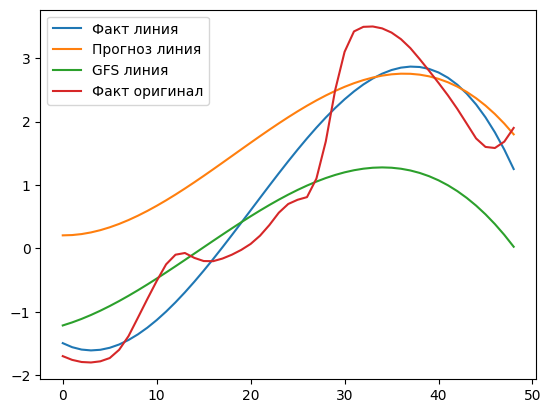

In [58]:
plot_lines(X_test_spl, y_test_spl, X_test, y_test, predicted, n=-6, from_coef=True)